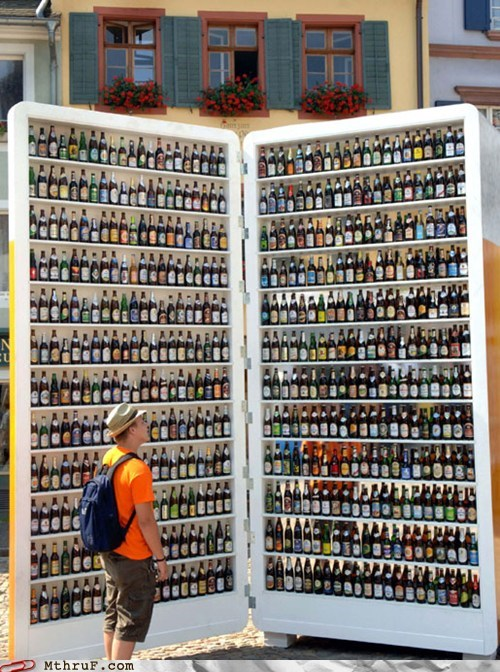

# Feature Selection

## Motivation

<p style="line-height:1.75;font-size:16px">
In most of our examples so far, we've had a small amount of features in our data that could be used to train a model. However, real-life problems that we'll encounter will probably have many features we could use but how do we know which ones will be useful?<br>

<div style="line-height:1.75;background:#3464a2;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px">
<i class="fa fa-question" style="font-size:40px;color:#e6f1ff;"></i>
</div>
<div>
<p style="line-height:1.75;font-size:16px;background:#e6f1ff;padding:20px;border-radius:0px 0px 5px 5px">
Why not just use all of the features and let the model decide which are important?
</p></div>

<p style="line-height:1.75;font-size:16px">
<b>Non-Informative Features</b><br>
In many cases, there will be some features that don't contribute anything to the final prediction, an ID field for example. This is just adds extra noise that our model needs to deal with.
<p style="line-height:1.75;font-size:16px">
<b>Simple Is Better</b><br>
Keeping our models simple make them easier to understand and interpret. This can also help when debugging a model if we see abnormal behavior.
<p style="line-height:1.75;font-size:16px">
<b>Faster Training</b><br>
Less features means less work our model has to do during training which allows us to test out more variants quicker.
<p style="line-height:1.75;font-size:16px">
<b>Less Data Required</b><br>
A model with a lot of features would require a larger dataset in order to cover the entire feature space. Also, if we have less features it also means there are fewer datapoint we need to collect.

## Solutions

<p style="line-height:1.75;font-size:16px">
<b>Filter Based</b><br>
Specify a metric and based on that filter features (e.g. correlation).
<p style="line-height:1.75;font-size:16px">
<b>Wrapper Based</b><br>
Treat feature selection as a search problem where we try different combinations of features until we find the one that gives us the best performance.
<p style="line-height:1.75;font-size:16px">
<b>Embedded</b><br>
Some models have built-in feature selection as a result of their algorithm (e.g. lasso regression).

## Learn From Example

<p style="line-height:1.75;font-size:16px">
We'll learn about some of the feature selection methods we can use in Python by working on a sample problem. For this, we'll use the FIFA 19 player dataset from <a href=https://www.kaggle.com/karangadiya/fifa19>Kaggle</a>. Our goal will be to predict what features make a great player.

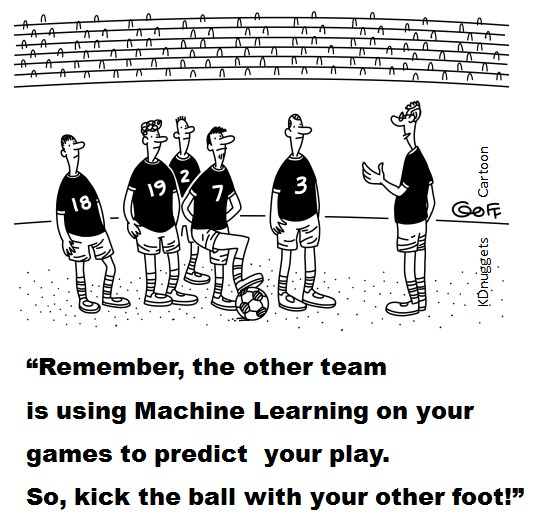

In [21]:
import pandas as pd

data = pd.read_csv('data/soccer.csv')
data.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [22]:
num_cols = ['Overall', 'Crossing','Finishing', 'ShortPassing', 'Dribbling', 'LongPassing', 'BallControl', 
           'Acceleration', 'SprintSpeed', 'Agility', 'Stamina', 'Volleys', 'FKAccuracy', 'Reactions', 'Balance',
           'ShotPower', 'Strength', 'LongShots', 'Aggression', 'Interceptions']
cat_cols = ['Preferred Foot', 'Position', 'Body Type', 'Nationality', 'Weak Foot']

data = pd.concat([data[num_cols], pd.get_dummies(data[cat_cols])], axis=1)
data = data.dropna()

y = data['Overall'] >= 87
X = data.drop('Overall', axis=1)

MAX_FEATURES = 30

### Pearson  Correlation

<center>
<h3>
$r=\frac{\sum(x-\bar{x})(y-\bar{y})}{\sqrt{\sum(x-\bar{x})^2\sum(y-\bar{y})^2}}$
</h3>
</center>
<p style="line-height:1.75;font-size:16px">
We'll check the absolute value of the Pearson’s correlation between the target and each numerical feature in our dataset and keep the top n features based on this criterion.

In [57]:
import numpy as np

def correlation_selector(X, y, features_num):
    correlations = []
    feature_names = X.columns

    for i in feature_names:
        correlation = np.corrcoef(X[i], y)[0, 1]
        correlations.append(correlation)
    
    # replace NaN with 0
    correlations = [0 if np.isnan(correlation) else correlation for correlation in correlations]
    feature_correlations = list(zip(feature_names, correlations))
    feature_correlations = sorted(feature_correlations, key=lambda x: np.abs(x[1]), reverse=True)
    return feature_correlations[:MAX_FEATURES]
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
results = correlation_selector(X, y,MAX_FEATURES)

for r in results:
    print(f'{r[0]: <30} {r[1]:.3f}')

Reactions                      0.151
Body Type_C. Ronaldo           0.135
Body Type_Messi                0.135
Body Type_Neymar               0.135
Body Type_Courtois             0.135
Body Type_PLAYER_BODY_TYPE_25  0.135
Position_LF                    0.068
Position_RF                    0.066
ShortPassing                   0.064
Volleys                        0.064
LongPassing                    0.063
FKAccuracy                     0.058
BallControl                    0.058
Finishing                      0.056
LongShots                      0.054
ShotPower                      0.051
Dribbling                      0.046
Nationality_Belgium            0.044
Crossing                       0.042
Agility                        0.041
Weak Foot                      0.041
Stamina                        0.035
Nationality_Slovenia           0.033
Nationality_Gabon              0.033
Strength                       0.032
SprintSpeed                    0.032
Acceleration                   0.031
N

### Chi Squared

<center>
<h3>
$\chi^2=\sum\limits_{i=1}^n\frac{(O_i-E_i)^2}{E_i}$
</h3>
</center>
$O_i~-~Observations~in~class~i$<br>
$E_i~-~Expected~observations~in~class~i~if~there~was~no~relationship~between~the~feature~and~the~target$

<p style="line-height:1.75;font-size:16px">
The intuition is that if a feature is independent to the target, it is uninformative for classifying observations. Let's understand this better with an example.

<center>
<h4>
Observed
</h4>
</center>
<table>
    <tr>
        <th>
        </th>
        <th>
            Great Player
        </th>
        <th>
            Not Great Player
        </th>
         <th>
            Total
        </th>
     </tr>
     <tr>
        <th>
            Not Rightforward
        </th>
        <td>
            20
        </td>
        <td>
            5
        </td>
         <td>
            25
        </td>
     </tr>
        <tr>
        <th>
            Rightforward
        </th>
        <td>
            50
        </td>
        <td>
            35
        </td>
         <td>
            75
        </td>
     </tr>
       <tr>
        <th>
            Total
        </th>
        <td>
            60
        </td>
        <td>
            40
        </td>
         <td>
            100
        </td>
     </tr>
</table>
<p style="line-height:1.75;font-size:16px">
In order to calculate the expected values, the values we'd see if there was no relationsip, we need to multiply the percentage of not right forward (25/100) by the total number of good players (60): $\frac{25}{100}\cdot60=15$.<br>
We repeat this process for all of the cells in the table and get:<p>

<center>
<h4>
Expected
</h4>
</center>
<table>
    <tr>
        <th>
        </th>
        <th>
            Great Player
        </th>
        <th>
            Not Great Player
        </th>
         <th>
            Total
        </th>
     </tr>
     <tr>
        <th>
            Not Rightforward
        </th>
        <td>
            15
        </td>
        <td>
            10
        </td>
         <td>
            25
        </td>
     </tr>
        <tr>
        <th>
            Rightforward
        </th>
        <td>
            45
        </td>
        <td>
            25
        </td>
         <td>
            75
        </td>
     </tr>
       <tr>
        <th>
            Total
        </th>
        <td>
            60
        </td>
        <td>
            40
        </td>
         <td>
            100
        </td>
     </tr>
</table>
<p style="line-height:1.75;font-size:16px">
We could then use the $\chi^2$ forumla from above to calculate the actual value. Let's see how it's done in Python.

In [70]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

chi_selector = SelectKBest(chi2, k=MAX_FEATURES)
chi_selector.fit(X, y)
chi_support = chi_selector.get_support()

feature_scores = list(zip(X.columns, chi_selector.scores_))
feature_scores = sorted(feature_scores, key=lambda x: np.abs(x[1]), reverse=True)[:MAX_FEATURES]
for r in feature_scores:
    print(f'{r[0]: <30} {r[1]:.3f}')

Reactions                      543.075
Volleys                        536.004
Finishing                      478.035
FKAccuracy                     439.651
LongShots                      417.862
Body Type_C. Ronaldo           329.164
Body Type_Courtois             329.164
Body Type_Messi                329.164
Body Type_Neymar               329.164
Body Type_PLAYER_BODY_TYPE_25  329.164
LongPassing                    316.758
BallControl                    293.177
ShortPassing                   273.549
ShotPower                      253.894
Dribbling                      243.366
Crossing                       219.460
Agility                        104.180
Stamina                        91.405
Position_LF                    84.345
Position_RF                    78.828
SprintSpeed                    62.775
Acceleration                   61.088
Interceptions                  46.374
Aggression                     46.199
Strength                       45.991
Nationality_Belgium            34

### Recursive Feature Elimination

<p style="line-height:1.75;font-size:16px">
From sklearn's documentation: The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature\_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.<br>
Since RFE is a wrapper method, it supports a wide variety of estimators. For this example we'll use logistic regression.

In [86]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

X_norm = MinMaxScaler().fit_transform(X)

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=MAX_FEATURES, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_features = X.loc[:, rfe_support].columns.tolist()
for f in rfe_features:
    print(f)

Fitting estimator with 223 features.
Fitting estimator with 213 features.
Fitting estimator with 203 features.
Fitting estimator with 193 features.
Fitting estimator with 183 features.
Fitting estimator with 173 features.
Fitting estimator with 163 features.
Fitting estimator with 153 features.
Fitting estimator with 143 features.
Fitting estimator with 133 features.
Fitting estimator with 123 features.
Fitting estimator with 113 features.
Fitting estimator with 103 features.
Fitting estimator with 93 features.
Fitting estimator with 83 features.
Fitting estimator with 73 features.
Fitting estimator with 63 features.
Fitting estimator with 53 features.
Fitting estimator with 43 features.
Fitting estimator with 33 features.
Finishing
ShortPassing
LongPassing
BallControl
SprintSpeed
Agility
Volleys
FKAccuracy
Reactions
Strength
Weak Foot
Position_CAM
Position_CM
Position_GK
Position_LCB
Position_LM
Position_RB
Position_RCB
Position_RF
Position_RM
Position_RW
Body Type_Courtois
Body Type_

### SelectFromModel

<p style="line-height:1.75;font-size:16px">
SelectFromModel uses a models built-in feature importance to select the most relevant features.

In [111]:
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

dt_selector = SelectFromModel(DecisionTreeClassifier(max_depth=20), max_features=MAX_FEATURES)
dt_selector.fit(X, y)

dt_support = dt_selector.get_support()
dt_features = X.loc[:, dt_support].columns.tolist()
for f in dt_features:
    print(f)

Crossing
Finishing
ShortPassing
LongPassing
BallControl
SprintSpeed
Volleys
Reactions
ShotPower
Strength
LongShots
Interceptions
Weak Foot
Position_CDM
Nationality_France
Nationality_Germany
Nationality_Slovenia


## Exercise

<div style="line-height:1.75;background:#1e7b1e;padding-left:20px;padding-top:5px;padding-bottom:5px;border-radius:5px 5px 0px 0px"><i class="fa fa-pencil" style="font-size:40px;color:#c1f0c1;"></i>
</div>
<div>
<p style="line-height:1.75;font-size:16px;background:#c1f0c1;padding:20px;border-radius:0px 0px 5px 5px">
We're going to use the Iowa housing dataset again but this time for classification. Separate the SalePrice column into 3 classes: price <= 135000, 135000 < price <= 180000, 180000 < price. After you've done that, use the feature selection techniques we learned about to create the best performing model. Bonus: Try to combine multiple techniques in order to select the best features.
</p>
</div>